# HW3 - Group 31

## Libraries

In [ ]:
import os
import csv
from bs4 import BeautifulSoup
import pandas as pd
import requests as rq
import time
import random
import unicodedata
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import *
import string
import re
from math import *
import json
from collections import defaultdict
from scipy import spatial
import heapq
from IPython.core.display import HTML
from IPython.display import display
import webbrowser
import os

### 1.1) Get the list of movies

In this step we get the list of all movies urls in the movies html files. Each member of the group used this code to get the list of movies and then html files.

In [ ]:
def get_movieList (path) :
    movies = pd.DataFrame(pd.read_html(path + "\\movies1.html")[0]) #put the content of html file in a dataframe and get the first column
    movies.drop('Id', inplace=True, axis = 1)
    return movies
path = os.getcwd() #The address of directory where Movies.html files exist
movies = get_movieList(path)  #this function will give us list of movies urls in the html file of movies which exist in the path address   

### 1.2) Crawl Wikipedia

Now, we crawl each wikipedia page to get html files

In [ ]:
def save_html(movies) :
    for i in range(len(movies)):
        try:
            response = rq.get(movies.URL[i])
        except rq.exceptions.RequestException as e: #if we got blocked by wiki we apply a time sleep
            print(e)
            time.sleep(20*60 + 30)
            response = rq.get(movies.URL[i])
        soup = BeautifulSoup(response.text, 'html.parser')
        f = open('article_'+str(i)+'.html','w')
        f.write(str(soup))
        f.close()
        time.sleep(random.choice(range(1,6)) #time sleep between each request
                   
save_html(movies)

### 1.3) Parse downloaded pages

In this step, we should parse HTML pages, get the specefic information we want and then save it as TSV files

After creating the function parse, contained in parser_utils, we just run the parser over the path that contains the complete database of the 30000 articles. The parser elaborates each article (wiki page) with the BeautilfulSoup package, and all the info needed (title, intro, ..., Language, Budget) are extracted from the bs object, and added to a tsv file for each article. The function doesn't return anything in the enviroment, but just creates a tsv file for each article, and stores it in another folder, that we called TSV, in the same path given as input. (full explanation of the parser can be found in parser_utils.py)

In [ ]:
import parser_utils

path1 = path + '\\Articles' #The address of directory where all html files exist 
parser_utils.parse(path1)

## 2) search engine

###  preprocessing

#### All the TSV Files were preprocessed by :
1) Tokenization

2) Removing stop words

3) Removing punctuation

4) Stemming

5) Removing [] , ""


In [ ]:

def clean(text):
    stop_words = set(stopwords.words('english')) 
    stemmer = PorterStemmer()
    text = text.lower()
    words = word_tokenize(text) #devide the text into substrings
    filtered1 = [w for w in words if not w in stop_words] #remove stop words
    filtered2 = list(filter(lambda word: word not in string.punctuation, filtered1))
    filtered3 = []
    for word in filtered2:
        try:
            filtered3 += re.findall(r'\w+', word) 
        except:
            pass
    
    filtered3 = [stemmer.stem(w) for w in filtered3] #stemming
    filtered4 = [c.replace("''", "").replace("``", "") for c in filtered3 ] #removing useless '' and  `` characters
    filtered4 = [f for f in filtered4 if len(f)>1]
    return filtered4

### 2.1) Conjunctive query

#### 2.1.1) creating index

In this section, we should first create a dictionary with all the words in our documents. The keys of this dictionary are integers(term_ids) and values are words.
Another dictionary that we create is docwords which points each document to list of all words in that document.
Another dictionary is tsvs which contains intro and plot section of each document.
we save these dictionaries  as json files to use afterwards in our code

In [ ]:
# this function save an object to desired path as a json file
def savetojson(pathfile, obj):
    with open(pathfile, "w" ,encoding="utf-8") as out_file:
        out_file.write(json.dumps(obj, ensure_ascii = False))
        out_file.close()
        
        
def get_vocab_index(path) :
    allwords = list()
    docwords = dict() # point each document to its containing words
    tsvs = dict()
    vocabulary = dict() # point each term id to a word
    for i in range(0,30000):
        with open(path+"\\TSV\\article_" + str(i) + ".tsv", encoding = "utf-8") as fd:
            rd = csv.reader(fd, delimiter="\t", quotechar='"')
            for row in rd:
                if row :
                    tsv = row
        text = ' '.join([tsv[1],tsv[2]]) #get intro and plot of each tsv file
        tsvs[i] = tsv
        cleared = clean(text)

        docwords['document_'+str(i)] = cleared
        allwords += cleared
        
        
    allwords = list(set(allwords)) # get the list of unique words
        for i in range(len(allwords)):
            vocabulary[str(i)] = allwords[i]
            
            
            
    savetojson(path+"\\tsvs.json", tsvs)
    savetojson(path + "\\WORDS\\DocWords.json", docwords)
    savetojson(path + "\\WORDS\\vocabulary.json", vocabulary)

Now, we should create inverted_index which points each term_id to the documents that contains that word. First we load vocabulary json file that we created in the previous step

In [ ]:
def get_inverted_index(path) :
    inverted = defaultdict(list)
    
    with open(path + "\\WORDS\\vocabulary.json", encoding = "utf-8") as fd:
        vocabulary = json.load(fd)
        
    reverse_voc = {v:k for k,v in vocabulary.items()} # we need to inverse keys and values of our dictionary
    
# we check for each document and for each word in that doument whether that document exist in inverted dictionary
#or not, and if it didn't exist we add the document number
    for doc in docwords.keys():
        for word in docwords[doc]:
            if not doc in inverted[reverse_voc[word]]:
                inverted[reverse_voc[word]].append(doc)
                
    savetojson(path + "\\WORDS\\Inverted_index.json", inverted)

#### 2.1.2) execute query

First, we get the query from user and replace each word with the term_id. If the word did not exist in vocabulary dictionary we assign NA to it

In [ ]:
def get_query():
    query = input("Insert your query: ")
    return(clean(query))

def get_query_index(query) :
    indexes = []
    for i in range(len(query)) :
        if query[i] in vocabulary.values() : #if the vocab in query exist in vocabulary dataset
            indexes.append(reverse_voc[query[i]]) #add term_id of that vocab to query

        else : #if it does not exist in vocabulary we replace it with 'NA'
            indexes.append('NA')
    return(indexes)

In this step, we should find the documents that contain all words of the query

In [ ]:
def execute_query(query):
    if len(query) == 0:
        return('Please, insert text in your search')
    query = get_query_index(query)
    docs = []
    for i in query :
        if (i == 'NA') : 
#if there is a vocab in query that does not exist in vocabulary dataset, there isn't a match and we should terminate the function
            return("No match for your query")
        else :
            docs.append(set(inverted_index[i]))
        
    docs = set.intersection(*docs)
    return(docs)

In this part we create some functions that we need to run and show the results

In [ ]:
def Linked_URL(val): #we will use this to make the urls in output clickable
        # target _blank to open new window
        return '<a target="_blank" href="{}">{}</a>'.format(val, val)
    
def replacer(val):      #This is used to escape the character $ in the output for Intro,
    return val.replace('$', '\$')      #otherwise it would be interpreted by displayer

def Run_SE1():
    query = get_query()
    results = []
    for file in execute_query(query):
        docid = file.split('_')[1]
        tsv = newdict[docid]
        results.append([docid,tsv[0],tsv[1],Movies[docid]])  #create movies file before
    df = pd.DataFrame(results, columns = ['Id','Title', 'Intro', 'Wikipedia Url'])
    f = open(path + '\\display.html','w', encoding = 'utf-8')
 
    message = df.style.format({'Wikipedia Url': Linked_URL}).format({'Intro': replacer}).render()

    f.write(message)
    f.close()

    #Change path to reflect file location
    filename = path + '\\display.html'
    webbrowser.open_new_tab(filename) # for showing the results in the browser

In [ ]:
def get_results(query):
    results = []
    for file in execute_query(query):
        docid = file.split('_')[1]
        tsv = newdict[docid]
        results.append([docid,tsv[0],tsv[1],Movies[docid]])  #create movies file before
    result = pd.DataFrame(results, columns = ['Id','Title', 'Intro', 'Wikipedia Url'])
    return result

### 2.2) Conjunctive query & Ranking score

In this part we should give scores based on cosine similarity


In [ ]:
def cosine_similarity(a,b):
    cosine_distance = spatial.distance.cosine
    return 1 - cosine_distance(a,b)

#### 2.2.1) Inverted index

what we need now is to calculate the IDF and TF - IDF, according to the formulas: 
- $TF = \frac{N_{(x,y)}}{N_{(*,y)}}$
- $IDF = log[1 + (\frac{D}{D_x})]$ <fr>

Where:
- $N_{(x,y)}$ is the number of times that the word $X$ is in the document $D_y$;
- $N_{(*,y)}$ is the total number of the words in the document;
- $D$ is the total number of documents;
- $D_x$ is the number of documents in which the word $X$ appears at least once.

In [ ]:
with open(path + "\\WORDS\\Inverted_index.json", encoding = "utf-8") as fd:
        inverted_index = json.load(fd

In [ ]:
with open(path + "\\WORDS\\DocWords.json", encoding = "utf-8") as fd:
        docwords = json.load(fd)

In [ ]:
IDFs = dict()
inv_ind_tfIDF = defaultdict(list)
for term in inverted_index.keys() :
        IDFs[term] = log(1+ 30000/len(inverted_index[term])) #first we calculat IDF for each term_id
        for doc in inverted_index[term] :
            tf = docwords[doc].count(vocabulary[term]) / len(docwords[doc])
            tfidf = tf * IDFs[term]
            inv_ind_tfIDF[term].append((doc,round(tfidf, 3))

In [ ]:
savetojson(path + "\\WORDS\\TfIdf_inv_index.json", inv_ind_tfIDF)

#### 2.2.2)Execute the query

We start calculating the tfidf values for words searched in the query, previoysly cleaned and tokenized.

In [ ]:
def querytf(query):
    qtf = dict()
    for word in query :
        term_id = reverse_voc[word]
        try :
            qtf[term_id] += 1/len(query)
            
        except :
            
            qtf[term_id] = 1/len(query)
    return(qtf)


With execute_SE2 we just take take the results from conjunct. query, get their ids, and then create a dictionary (wordtf) that stores the list of tfidf values for words contained in each document of the conjunctive query result.

In [ ]:

def execute_SE2(query) :
    results = get_results(query)
    ids = get_query_index(query)
    wordtf = defaultdict(list)
    for i in results['Id']:
        doc = 'document_'+str(i)
        for term in ids:
            for docs in inv_ind_tfIDF[term]:
                if docs[0] == doc:
                    wordtf[i].append(docs[1])
        
    return(wordtf)



Run_SE2 will just take the functions defined previously to build a heap structure based on cosine similarity between query and each document. The result will be the first 10 pages sorted by cosine similarity, displayed in display.html page.

In [ ]:
def Run_SE2():
    query = get_query()
    wordtf = execute_SE2(query)
    qtfs = querytf(query)
    list_query = list(qtfs.values())

    heap = []
    for doc in wordtf:
        heapq.heappush(heap, (cosine_similarity(list_query, wordtf[doc]), doc))

    heap_result = heapq.nlargest(10, heap)
    df = dict()
    for x,y in heap_result:
        df[y] = newdict[y][0:2]
        df[y].append(Movies[y])
        df[y].append(x)

    df = pd.DataFrame.from_dict(df, orient = 'index', columns=['Title', 'Intro', 'Wikipedia Url', 'Score'])
    f = open(path + '\\display.html','w', encoding = 'utf-8')
 
    message = df.style.format({'Wikipedia Url': Linked_URL}).format({'Intro': replacer}).render()

    f.write(message)
    f.close()

    filename = path + '\\display.html'
    webbrowser.open_new_tab(filename)


## Defining a new score

In this step we should define some variables to calculate the new scores based on them. The variables that we decided to use are : The release Year, length of the movie(Run time), Budget and number of stars as these variables seems to be more important to most of users. First we get  some queries from user and based on maximum and minimum value of these varaibles among resulted documents of the first search engine we define a scoring function for each variable that gives a score between 0 and 1. Finally we calculate the mean of these scores and put them in a heap structure to find 10 documents that have most scores

In [ ]:
#getting query from user
def get_query_SE3():
    query = input("insert your query : ")
    query = clean(query)
    q = dict()
    
    year = input("Do you want to specify the release year ? [Y/N] : ").lower()
    if year == "y" :
        year = input("Please, specify the release date : ") 
        q["year"] = year
    else:
        q["year"] = 'NA'
    



    Runtime = input("Do you want to specify the length of the movie? [Y/N] : ").lower()
    if Runtime == "y" :
        Runtime = input("Please, specify the length of the movie : ")
        if re.search('\d', Runtime):
            q['Runtime'] = Runtime
        else:
            return 'Please, enter a valid runtime.'
    else :
        q["Runtime"] = 'NA'


    starring = input("Is number of stars an important factor for you? [Y/N] : ").lower()
    if starring == "y" :
        starring = input("Please, specify if you're looking for a big or small cast [B/S]: ")
        q["starring"] = starring
    else :
        q["starring"] = 'NA'


    budget = input("Is movie budget an important factor for you? [Y/N] : ").lower()
    if budget == "y" :
        q['Budget'] = input("Please, specify the budget of the movie you're looking for : ")
    else :
        q['Budget'] = 'NA'
        
    return query,q

Now we should execute our search engine with the query

In [ ]:
def search_engine3() :
    (query, q) = get_query_SE3()
    results = execute_query(query)    #running the first search engine to get all query_related documents 
                                    # Now we should define variables that we want to use to give a new score
    d = defaultdict(dict)
    result_variables = dict() # A dictionary that assigns each document to a dictionary of variables in that document
     # A dictionary that
    for i in results :
        docId = i.split("_")[1] 
        tsv = newdict[docId]


        d[i] = dict()

        if tsv[6] == 'NA':
            d[i]['Starring'] = '-10000'
        else:
            d[i]['Starring'] = str(len(tsv[6].replace('\n', '').strip(',').split(',,')))

        try:
            d[i]['Release Year'] = re.search(r'\d{4}', tsv[8]).group(0)
        except:
            d[i]['Release Year'] = '-10000'

        try:
            d[i]['Runtime']    = re.search(r'\d+.*',tsv[9]).group(0)
        except:
            d[i]['Runtime']    = '-10000'

        #some movies have running time expressed in reels, and the conversion in minutes is not univoque, so we'll just ignore those info
        if re.search(r'min', d[i]['Runtime']):
            d[i]['Runtime'] = re.search(r'\d+[\.|\,|:]*\d*', d[i]['Runtime']).group(0)
            d[i]['Runtime'] = re.search(r'\d+', d[i]['Runtime']).group(0)
        else:
            d[i]['Runtime'] = '-10000'

        try:
            d[i]['Budget']   = re.findall(r'\$.*', tsv[12])[0]
        except:
            d[i]['Budget']  = '-10000'


        if re.search(r'mil', d[i]['Budget']):
            d[i]['Budget']  = str(int(float(re.search(r'\d+[\.|\,]*\d*', d[i]['Budget']).group(0).replace(',', '.'))*10**6))

        elif re.search(r'\,', d[i]['Budget']) or re.search(r'\.', d[i]['Budget']):
            d[i]['Budget'] = re.search(r'(\d+[\,!\.])+\d+', d[i]['Budget']).group(0).replace(',', '').replace('.', '')


        result_variables[docId] = d[i]

        Runtimes = []

    Release_year = []
    Starring = []
    Budget = []

    for i in result_variables.keys() :
        i = 'document_'+str(i)
        Runtimes.append(int(d[i]["Runtime"]))
        Release_year.append(int(d[i]["Release Year"]))
        Starring.append(int(d[i]["Starring"]))
        Budget.append(int(d[i]["Budget"]))
    scores = dict()
    for i in result_variables :
        # calculating score for Running time
        i = 'document_'+ str(i)
        minrun = min(Runtimes)
        maxrun = max(Runtimes)
        if re.search('\d', q['Runtime']):
            run_score = exp(-(int(re.search('\d+', q['Runtime']).group(0)) -int(d[i]['Runtime']))**2/100)
        else:
            run_score = 0


       # calculating score for quantitative Release_year query
        if re.search('\d', q['year']):
            distance = abs(int(d[i]['Release Year']) - int(re.search('\d+',q["year"]).group(0)))
            year_score = exp(-distance/10)
        else:
            year_score = 0


      # calculating score for budget

        if re.search('\d', q['Budget']):
            if re.search(r'mil', q['Budget']):
                Budget  = int(float(re.search(r'\d+[\.|\,]*\d*', q['Budget']).group(0).replace(',', '.'))*10**6)

            elif re.search(r'\,', q['Budget']) or re.search(r'\.', q['Budget']):
                Budget = int(re.search(r'(\d+[\,!\.])+\d+', q['Budget']).group(0).replace(',', '').replace('.', ''))


            budget_score = exp(-abs(int(Budget) - int(d[i]['Budget'])) / 10**5)
        else:
            budget_score = 0

    # calculating score for starring
        maxstar = max(Starring)
        minstar = min(Starring)
        if q['starring'] == 'B':
            starring_score = (maxstar - int(d[i]['Starring']))/(maxstar-minstar)
        elif q['starring'] == 'S':
            starring_score = (int(d[i]['Starring']) - minstar)/(maxstar-minstar)
        else:
            starring_score = 0

        mean_score = 1/4 * (run_score + year_score + budget_score + starring_score)
        scores[i] = (mean_score, i)
        
# use heap structure to sfine the 10 best score
    heap = []
    for doc in scores:
        heapq.heappush(heap, scores[doc])
    heap_result = heapq.nlargest(10, heap)
    df = dict()
    for x,z in heap_result:
        y = z.split('_')[1]
        df[y] = newdict[y][0:2]
        df[y].append(Movies[y])
        df[y].append(x)

    df = pd.DataFrame.from_dict(df, orient = 'index', columns=['Title', 'Intro', 'Wikipedia UrlL', 'Score'])
    f = open(path + '\\display.html','w', encoding = 'utf-8')
 
    message = df.style.format({'Wikipedia Url': Linked_URL}).format({'Intro': replacer}).render()

    f.write(message)
    f.close()

    #Change path to reflect file location
    filename = path + '\\display.html'
    webbrowser.open_new_tab(filename)

# Bonus - Create a co-stardom network

In [140]:
import networkx as nx
import matplotlib.pyplot as plt
from Functions import *
import seaborn as sns


First we should insert a query and get the results from the third search engine

In [2]:
(query, q) = get_query_SE3()

insert your query : orcs elves
Do you want to specify the release year ? [Y/N] : y
Please, specify the release date : 2000
Do you want to specify the length of the movie? [Y/N] : y
Please, specify the length of the movie : 179
Is number of stars an important factor for you? [Y/N] : y
Please, specify if you're looking for a big or small cast [B/S]: B
Is movie budget an important factor for you? [Y/N] : y
Please, specify the budget of the movie you're looking for : 20 milions


In [2]:
query, q = (['orc', 'elv'],
 {'year': '1995', 'Runtime': 'NA', 'starring': 'NA', 'Budget': '20 milions'})
result = search_engine3(query, q) 


In [9]:
result.index

Index(['13821', '14018', '14227', '9469', '16462', '17005', '17279'], dtype='object')

Now we need to finde nodes and edges. Nodes of this network, are all star actors in the documents that we found in the previous step, and edges are any duel combination of these actors that exist in at least 2 documents.

In [44]:
newdict['14018'] #from the functions import, newdict is the dictionary of all tsv's

['The Lord of the Rings: The Two Towers',
 "The Lord of the Rings: The Two Towers is a 2002 epic fantasy adventure film directed by Peter Jackson, based on the second volume of J. R. R. Tolkien's The Lord of the Rings. The film is the second instalment in The Lord of the Rings trilogy and was produced by Barrie M. Osborne, Fran Walsh and Jackson, and written by Walsh, Philippa Boyens, Stephen Sinclair and Jackson. The film features an ensemble cast including Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mortensen, Sean Astin, Cate Blanchett, John Rhys-Davies, Bernard Hill, Christopher Lee, Billy Boyd, Dominic Monaghan, Orlando Bloom, Hugo Weaving, Miranda Otto, David Wenham, Brad Dourif, Karl Urban and Andy Serkis. It was preceded by The Fellowship of the Ring (2001) and followed by The Return of the King (2003).Continuing the plot of The Fellowship of the Ring, the film intercuts three storylines. Frodo and Sam continue their journey towards Mordor to destroy the One Ring, meeting and j

In [116]:
stars = [] #set of star actors in 10 first result of search engine
for ind in result.index :
    tsv = newdict[str(ind)]
    for i in tsv[6].replace('\n', '').strip(',').split(',,') : #stars of a movie
        if i not in stars :
            stars.append(i) 
    

In [117]:
stars

['Elijah Wood',
 'Ian McKellen',
 'Liv Tyler',
 'Viggo Mortensen',
 'Sean Astin',
 'Cate Blanchett',
 'John Rhys-Davies',
 'Billy Boyd',
 'Dominic Monaghan',
 'Orlando Bloom',
 'Christopher Lee',
 'Hugo Weaving',
 'Sean Bean',
 'Ian Holm',
 'Andy Serkis',
 'Bernard Hill',
 'Miranda Otto',
 'David Wenham',
 'Brad Dourif',
 'Karl Urban',
 'John Noble',
 'Christopher Guard',
 'William Squire',
 'Michael Scholes',
 'John Hurt',
 'Simon Chandler',
 'Dominic Guard',
 'Michael Graham Cox',
 'Anthony Daniels',
 'David Buck',
 'Martin Freeman',
 'Richard Armitage',
 'Benedict Cumberbatch',
 'Evangeline Lilly',
 'Lee Pace',
 'Luke Evans',
 'Stephen Fry',
 'Ken Stott',
 'James Nesbitt',
 'Travis Fimmel',
 'Paula Patton',
 'Ben Foster',
 'Dominic Cooper',
 'Toby Kebbell',
 'Ben Schnetzer',
 'Robert Kazinsky',
 'Clancy Brown',
 'Daniel Wu',
 'Will Smith',
 'Joel Edgerton',
 'Noomi Rapace',
 'Lucy Fry',
 'Édgar Ramírez',
 'Ike Barinholtz']

Now we have nodes of our network. In order to create edges, first we shoud make a list of all possible duel combination 

In [79]:
duel_stars = []
for i in range(0 , len(stars)) :
    for j in range(i+1,len(stars)) :
        duel_stars.append((stars[i],stars[j])) #make a nested list with all possible duel combination 


In this step we should check which duel combinations that we created in previous step, exist in more than 2 documents

In [124]:
edge = []
nodes = set()
for x,y in duel_stars : #for each dual combination
    counter = 0
    for j in result.index: # search in the whole dataset
        tsv = newdict[str(j)]
        starring = tsv[6].replace('\n', '').strip(',').split(',,')
        if len(set((x,y)).intersection(set(starring))) == 2:
            counter += 1
            if counter == 2:
                edge.append((x,y))
                nodes.add(x)
                nodes.add(y)
                break               
            
       

In [126]:
nodes

{'Andy Serkis',
 'Bernard Hill',
 'Billy Boyd',
 'Cate Blanchett',
 'Christopher Lee',
 'David Wenham',
 'Dominic Monaghan',
 'Elijah Wood',
 'Hugo Weaving',
 'Ian Holm',
 'Ian McKellen',
 'John Rhys-Davies',
 'Karl Urban',
 'Liv Tyler',
 'Miranda Otto',
 'Orlando Bloom',
 'Sean Astin',
 'Sean Bean',
 'Viggo Mortensen'}

Now we have Nodes and Edges. It's time to create a network

# Creating co-stardom network

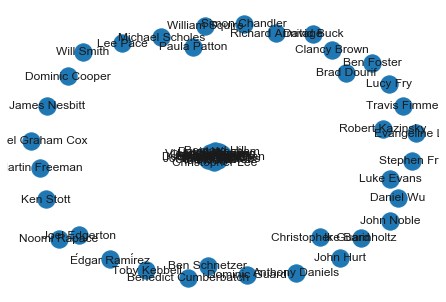

<Figure size 1440x1440 with 0 Axes>

In [157]:
G = nx.Graph()
G.add_nodes_from(stars)
G.add_edges_from(edge)
nx.draw(G, with_labels = 5)
plt.savefig("co-stardom.png", format = 'png')
plt.show()




To make a better visualization, we position unlinked nodes aside, and the linked nodes in the center, so that the names (most of them) are readable.

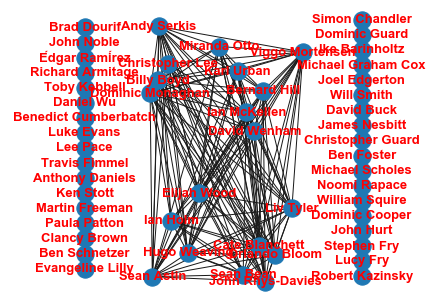

In [284]:
G = nx.Graph()

G.add_nodes_from(stars)
G.add_edges_from(edge)
pos = dict()

c = 0

for i in set(stars)-nodes:
    c+=1
    if c%2 ==0:
        m = 0
    else:
        m = 1
    pos[i] = (m*250, c*15)
    
for i in nodes:
    pos[i] = (random.choice(range(50,200)), random.choice(range(1,c*15)))
nx.draw(G, pos, with_labels=True, font_color = 'red', font_size = 13, font_weight = 'bold')
plt.xlim([-70, 320])
plt.savefig("co-stardom.png")



Since the movies resulted from the query were few, and most of them were from the Lord of the Rings trilogy, we have a network in which all of the actors from the trilogy are linked, and actors from the remaining movies that didn't act in Lord of the rings are unlinked, because they acted together only once.

# Analysis

Let's do some analysis on this network. We can make a density distribution histogram which shows the number of connections for each node

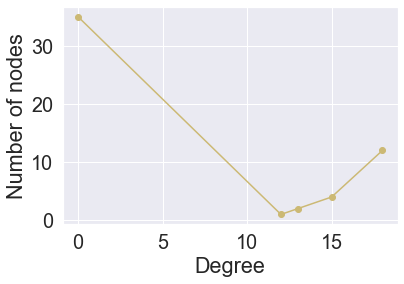

In [158]:
all_degrees =[val for (node, val) in G.degree()]
unique_degrees = list(set(all_degrees))
count = []
for i in unique_degrees :
    x = all_degrees.count(i)
    count.append(x)
plt.plot(unique_degrees , count, "yo-")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

We can calculate degree centality for each node to see which actors where more involved with other actors(most influential)

In [159]:
nx.degree_centrality(G)

{'Elijah Wood': 0.33962264150943394,
 'Ian McKellen': 0.33962264150943394,
 'Liv Tyler': 0.33962264150943394,
 'Viggo Mortensen': 0.33962264150943394,
 'Sean Astin': 0.33962264150943394,
 'Cate Blanchett': 0.33962264150943394,
 'John Rhys-Davies': 0.33962264150943394,
 'Billy Boyd': 0.33962264150943394,
 'Dominic Monaghan': 0.33962264150943394,
 'Orlando Bloom': 0.33962264150943394,
 'Christopher Lee': 0.22641509433962265,
 'Hugo Weaving': 0.33962264150943394,
 'Sean Bean': 0.24528301886792453,
 'Ian Holm': 0.24528301886792453,
 'Andy Serkis': 0.33962264150943394,
 'Bernard Hill': 0.2830188679245283,
 'Miranda Otto': 0.2830188679245283,
 'David Wenham': 0.2830188679245283,
 'Brad Dourif': 0.0,
 'Karl Urban': 0.2830188679245283,
 'John Noble': 0.0,
 'Christopher Guard': 0.0,
 'William Squire': 0.0,
 'Michael Scholes': 0.0,
 'John Hurt': 0.0,
 'Simon Chandler': 0.0,
 'Dominic Guard': 0.0,
 'Michael Graham Cox': 0.0,
 'Anthony Daniels': 0.0,
 'David Buck': 0.0,
 'Martin Freeman': 0.0,
 'R

In [160]:
sorted(nx.degree_centrality(G), key = nx.degree_centrality(G).get , reverse = True)

['Elijah Wood',
 'Ian McKellen',
 'Liv Tyler',
 'Viggo Mortensen',
 'Sean Astin',
 'Cate Blanchett',
 'John Rhys-Davies',
 'Billy Boyd',
 'Dominic Monaghan',
 'Orlando Bloom',
 'Hugo Weaving',
 'Andy Serkis',
 'Bernard Hill',
 'Miranda Otto',
 'David Wenham',
 'Karl Urban',
 'Sean Bean',
 'Ian Holm',
 'Christopher Lee',
 'Brad Dourif',
 'John Noble',
 'Christopher Guard',
 'William Squire',
 'Michael Scholes',
 'John Hurt',
 'Simon Chandler',
 'Dominic Guard',
 'Michael Graham Cox',
 'Anthony Daniels',
 'David Buck',
 'Martin Freeman',
 'Richard Armitage',
 'Benedict Cumberbatch',
 'Evangeline Lilly',
 'Lee Pace',
 'Luke Evans',
 'Stephen Fry',
 'Ken Stott',
 'James Nesbitt',
 'Travis Fimmel',
 'Paula Patton',
 'Ben Foster',
 'Dominic Cooper',
 'Toby Kebbell',
 'Ben Schnetzer',
 'Robert Kazinsky',
 'Clancy Brown',
 'Daniel Wu',
 'Will Smith',
 'Joel Edgerton',
 'Noomi Rapace',
 'Lucy Fry',
 'Édgar Ramírez',
 'Ike Barinholtz']